# Notebook to correlate vis 0.6 spectra of satellite images and measured sun intensity from weather stations

In [1]:
#### Functions to load data

from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from collections import defaultdict
import rasterio
from datetime import datetime
from tensorflow import keras
from PIL import Image
from matplotlib.patches import Circle
from datetime import date

## Locations of weather stations


Tallinn-Harku
Laius: N 59°23´53´´
Pikkus: E 24°36´10´´
Decimal
Lat: 59.398055
Long: 24.602778


Haapsalu meteoroloogiajaam
Laius N 58°56´40´´
Pikkus E 23°33´18´´
Decimal
Lat: 58.944444
Long: 23.555

Narva
Laius: N 59°23´22´´
Pikkus: E 28°06´33´´
Decimal
Lat: 59.389444
Long: 28.109167

Pärnu
Laius: N 58°23´4,44´´
Pikkus: E 24°29´6,71´´
Decimal
Lat: 58.384556
Long: 24.485197

Roomassaare
Laius: N 58°13’05”
Pikkus: E 22°30’23”
Decimal
Lat: 58.218056 
Long: 22.506389 

Tartu-Tõravere meteoroloogiajaam
Laius: N 58°15´51´´
Pikkus: E 26°27´41´
Decimal
Lat: 58.264167
Long: 26.461389

Tiirikoja järvejaam
Laius: N 58°51´55´´
Pikkus: E 26°57´08´´
Decimal
Lat: 58.865278
Long: 26.952222

Vilsandi rannikujaam
Laius: N 58°22´58”
Pikkus: E 21°48´51”
Deciaml
Lat: 58.382778
Long: 21.814167

In [2]:
weather_station_coordinates = dict()
weather_station_coordinates["Tallinn-Harku"] = [59.398055, 24.602778]
#weather_station_coordinates["Haapsalu"] = [58.944444, 23.555]
weather_station_coordinates["Narva"] = [59.389444, 28.109167]
weather_station_coordinates["Pärnu"] = [58.384556, 24.485197]
weather_station_coordinates["Roomassaare"] = [58.218056, 22.506389]
weather_station_coordinates["Tartu-Tõravere"] = [58.264167, 26.461389]
weather_station_coordinates["Tiirikoja"] = [58.865278, 26.952222]
weather_station_coordinates["Vilsandi"] = [58.382778, 21.814167]

## Load satellite images

In [3]:


"""
Function for loading the satellite images
Arguments:
 selectedDataset - can be "2019-07" - e.g. specific month
                          "" - all months
 pictureTypes - list defining what sort of constellations are loaded
                "dnc" - 
                "dnm" - 24-hour Microphysics RGB

 pictureSize - Size to resize images to after they are read from disk. Defaults to (256, 256).
Returns:
  2 dictionaries
  dates - dates corresponding to pictures
  pictures - satellite pictures
"""


def loadSatelliteImages(selectedDatasets=["2019-07"], pictureTypes=["dnc", "dnm"], pictureSize=(256, 256)):
    pictures = defaultdict(lambda: defaultdict(list))
    dates = defaultdict(lambda: defaultdict(list))

    for selectedDataset in selectedDatasets:
        for pictureType in pictureTypes:
            satellitePictureNames = os.listdir(os.path.join(".", "data", selectedDataset, pictureType))

            for satellitePictureName in satellitePictureNames:
                # Load image
                imageDateStr = satellitePictureName.replace("dnc-", "").replace("dnm-", "").replace(".png", "")
                #Parse date to datetime 2019-07-01-05-45
                imageDate = datetime.strptime(imageDateStr, "%Y-%m-%d-%H-%M")
                img = image.load_img(os.path.join(".", "data", selectedDataset,
                                                  pictureType, satellitePictureName),
                                     target_size=pictureSize)
                # Convert to np array and add to list
                pictures[selectedDataset][pictureType].append(np.array(img))
                dates[selectedDataset][pictureType].append(imageDate)
            dates[selectedDataset][pictureType] = np.array(dates[selectedDataset][pictureType])
            pictures[selectedDataset][pictureType] = np.array(pictures[selectedDataset][pictureType])
            #Argsort
            sortedDates = np.argsort(dates[selectedDataset][pictureType])
            dates[selectedDataset][pictureType] = dates[selectedDataset][pictureType][sortedDates]
            pictures[selectedDataset][pictureType] = pictures[selectedDataset][pictureType][sortedDates]

    return pictures, dates


In [4]:
###### Some important variables

#npixel = 128 # Define the pixel size of images
npixel = 128
pictureType = ["dnc"]#, "dnm"]

In [5]:
sat, labels = loadSatelliteImages(selectedDatasets=["2019-07","2019-08","2019-09"], pictureTypes=pictureType, pictureSize=(npixel, npixel))

## Relate points in satellite image to weather station coordinates

In [6]:
def findPixel(latsMatrix, lonsMatrix, coordLat, coordLon):
    #Iterate over lattitude and longitude matrix to find coord
    accuracyDif = 0.07
    for i in range(len(latsMatrix)):
        for j in range(len(lonsMatrix[i])):
            currentLat = latsMatrix[i][j]
            currentLon = lonsMatrix[i][j]
            if(np.abs(currentLat-coordLat)<accuracyDif):
                if(np.abs(currentLon-coordLon)<accuracyDif):
                    return (j, i)
    #Nothing was found return
    return (None, None)

In [7]:
def resizeLatsLonsMatrix(latsMatrix, lonsMatrix, targetSize):
    result = [latsMatrix, lonsMatrix]
    for i in range(len(result)):
        pil = Image.fromarray(result[i])
        resized = pil.resize((targetSize,targetSize))
        resizedArray = np.array(resized)
        result[i] = resizedArray
    return result

In [8]:
#The initial coordinate matrix is for images 650x650
lats650 = np.load("./OstlandA/OstlandA-lats.npy")
lons650 = np.load("./OstlandA/OstlandA-lons.npy")
#Convert them to size (npixel x npixel)
lats_npixel, lons_npixel = resizeLatsLonsMatrix(lats650, lons650, npixel)

In [9]:
#Find the pixels where the weather stations are located
weather_station_loc_pixels = dict()
for station in weather_station_coordinates.keys():
    weather_station_loc_pixels[station]=findPixel(lats_npixel, lons_npixel, 
                          weather_station_coordinates[station][0], 
                          weather_station_coordinates[station][1])


In [10]:
weather_station_loc_pixels

{'Tallinn-Harku': (65, 51),
 'Narva': (92, 42),
 'Pärnu': (68, 71),
 'Roomassaare': (53, 79),
 'Tartu-Tõravere': (85, 68),
 'Tiirikoja': (86, 55),
 'Vilsandi': (47, 77)}

In [11]:
sat["2019-08"][pictureType[0]][8][59,63]

array([17, 32, 21], dtype=uint8)

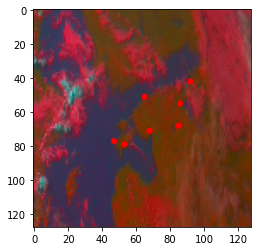

In [12]:
#Check that the locations are correct on one random image
fig, ax = plt.subplots(1)
ax.imshow(sat["2019-08"][pictureType[0]][450])
for station in weather_station_loc_pixels.keys():
    ax.add_patch(Circle((weather_station_loc_pixels[station][0],weather_station_loc_pixels[station][1]), radius=1.5, color="red"))

## Load solar intensity data from weather stations

In [13]:
# Some weather stations have changed locations over time, as the differences between their locations are rather small (less than 8 km)
# We at first do not make separation between them

def join_columns(c1, c2, nc, df, column_id): # Function for joining columns, where an area has two weather measuring points
    data = []
    cs = [c1, c2]
    for i, rows in df[cs].iterrows():
        if (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == False):
            data.append(round(rows[1], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == True):
            data.append(round(rows[0], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == False):
            data.append(round(rows.mean(), 2))
        elif (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == True):
            data.append(rows[0])

    df = df.drop(columns = [c1, c2])
    df.insert(column_id, nc, data)
    
    return df

In [14]:
#Create datetime object from year, month and day
def createDateTimeColumn(df):
    dateTimes = []
    for i in range(len(df)):
        row = df.iloc[i]
        dateTimes+=[datetime.combine(date(row.y, row.m, row.d), row.time)]
    df["dateTime"] = dateTimes

In [15]:
#Load initial data
hourly_sun_intensity = pd.read_excel('./data/2-10_21_524-2 Andmed.xlsx', sheet_name = 'tunni sum.kiirgus', header = 1)

In [16]:
#Update column names by shortening them and converting to English
newColumnNames = dict()
newColumnNames["Aasta"] = "y"
newColumnNames["Kuu"] = "m"
newColumnNames["Päaev"] = "d"
newColumnNames["Kell (UTC)"] = "time"

for columnName in hourly_sun_intensity.columns:
    if "kiirgus" in columnName:
        newColumnNames[columnName] = "solar_"+columnName.replace(" summaarne kiirgus, W/m²", "")
hourly_sun_intensity = hourly_sun_intensity.rename(columns=newColumnNames)


In [17]:
#Merge columns, which are due to weather station moving
hourly_sun_intensity = join_columns('solar_Narva', 'solar_Narva-Jõesuu', 'solar_Narva', hourly_sun_intensity, 4)
hourly_sun_intensity = join_columns('solar_Pärnu-Sauga', 'solar_Pärnu', 'solar_Pärnu', hourly_sun_intensity, 5)

In [18]:
#hourly_sun_intensity

In [19]:
#Drop rows where some value is missing
hourly_sun_intensity = hourly_sun_intensity.dropna()
#If value is -1 it corresponds to night, set it to 0
hourly_sun_intensity = hourly_sun_intensity.replace(-1, 0)

#Drop rows where sun is not shined for an hour
#for columnName in hourly_sun_intensity.columns:
#    print(columnName)
#    if "solar" in columnName:
#        hourly_sun_intensity = hourly_sun_intensity[hourly_sun_intensity[columnName]!=0]

In [20]:
hourly_sun_intensity

,y,m,d,time,solar_Narva,solar_Pärnu,solar_Haapsalu,solar_Tallinn-Harku,solar_Roomassaare,solar_Tartu-Tõravere,solar_Tiirikoja,solar_Vilsandi
2484,2010,4,14,12:00:00,634.0,384.0,652.0,603,673.0,371,380.0,676.0
2485,2010,4,14,13:00:00,552.0,297.0,577.0,540,611.0,328,361.0,610.0
2486,2010,4,14,14:00:00,450.0,381.0,484.0,441,511.0,317,361.0,521.0
2487,2010,4,14,15:00:00,326.0,375.0,384.0,319,380.0,265,335.0,397.0
2488,2010,4,14,16:00:00,117.0,239.0,250.0,189,237.0,101,199.0,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...
96427,2020,12,31,19:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0
96428,2020,12,31,20:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0
96429,2020,12,31,21:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0
96430,2020,12,31,22:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0


In [21]:
#Create datetime object column for finding matching satellite images and rows of weather station data
createDateTimeColumn(hourly_sun_intensity)

In [22]:
hourly_sun_intensity.columns

Index(['y', 'm', 'd', 'time', 'solar_Narva', 'solar_Pärnu', 'solar_Haapsalu',
       'solar_Tallinn-Harku', 'solar_Roomassaare', 'solar_Tartu-Tõravere',
       'solar_Tiirikoja', 'solar_Vilsandi', 'dateTime'],
      dtype='object')

In [64]:
hourly_sun_intensity.describe()

,y,m,d,solar_Narva,solar_Pärnu,solar_Haapsalu,solar_Tallinn-Harku,solar_Roomassaare,solar_Tartu-Tõravere,solar_Tiirikoja,solar_Vilsandi
count,88788.000000,88788.000000,88788.000000,88788.000000,88788.000000,88788.000000,88788.000000,88788.000000,88788.000000,88788.000000,88788.000000
mean,2015.158907,6.587872,15.792078,112.948293,117.667951,114.756544,113.180328,126.094033,115.880603,112.650786,124.480527
std,3.081945,3.403052,8.781745,192.715940,198.790720,196.087648,193.198241,209.548204,191.901672,189.882892,206.588459
min,2010.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2013.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,7.000000,16.000000,3.000000,3.000000,1.000000,2.000000,3.000000,6.000000,4.000000,5.000000
75%,2018.000000,9.000000,23.000000,140.000000,153.000000,146.000000,144.000000,168.000000,153.000000,147.000000,161.000000
max,2020.000000,12.000000,31.000000,932.000000,925.000000,941.000000,902.000000,952.000000,886.000000,921.000000,890.000000


## Load weather data from weather stations

In [23]:
selectedColumns = ["Aasta", "Kuu", "Päev", "Kell (UTC)", "Õhutemperatuur °C","Suhteline õhuniiskus %"]

In [24]:
#Update column names by shortening them and converting to English

def updateColumnNames(df, location):
    newColumnNames = dict()
    newColumnNames["Aasta"] = "y"
    newColumnNames["Kuu"] = "m"
    newColumnNames["Päev"] = "d"
    newColumnNames["Kell (UTC)"] = "time"
    newColumnNames["Õhutemperatuur °C"] = f"temp_{location}"
    newColumnNames["10 minuti keskmine tuule kiirus m/s"] = f"wind_speed_{location}"
    newColumnNames["Õhurõhk jaama kõrgusel hPa"] = f"pressure_{location}"
    newColumnNames["Suhteline õhuniiskus %"] = f"rel_humidity_{location}"
    newColumnNames["10 minuti keskmine tuule suund"] = f"wind_dir_{location}"
    df = df.rename(columns=newColumnNames)
    return df

In [25]:
def getFromXlsx(filename, columns, location):
    #Load xlsx
    df = pd.read_excel(filename, header = 1)
    df = df[columns]
    #Drop rows where data is missing
    #df = df.dropna()
    #Update column names for clarity
    df = updateColumnNames(df, location)
    return df

In [26]:
weather_station_loc_pixels.keys()

dict_keys(['Tallinn-Harku', 'Narva', 'Pärnu', 'Roomassaare', 'Tartu-Tõravere', 'Tiirikoja', 'Vilsandi'])

In [27]:
#Get Tallinn
data_tallinn = getFromXlsx("./data/Tallinn-Harku_2004-2020.xlsx", selectedColumns, 'Tallinn-Harku')
#Get Roomassaare
data_roomassaare = getFromXlsx("./data/Roomassaare_2008-2020.xlsx", selectedColumns, 'Roomassaare')
#Merge tables
data_weather = data_tallinn.merge(data_roomassaare, how='left', on=["y", "m", "d", "time"])

In [28]:
#Get Vilsandi
data_vilsandi = getFromXlsx("./data/Vilsandi_2004-2020.xlsx", selectedColumns, "Vilsandi")
#Merge tables
data_weather = data_weather.merge(data_vilsandi, how='left', on=["y", "m", "d", "time"])

In [29]:
##Get Parnu
data_parnu1 = getFromXlsx("./data/Parnu-Sauga_01.12.2004-31.03.2019.xlsx", selectedColumns, 'Pärnu')
data_parnu2 = getFromXlsx("./data/Parnu_01.04.2019-2020.xlsx", selectedColumns, 'Pärnu')
data_parnu = data_parnu1.append(data_parnu2)
##Merge tables
data_weather = data_weather.merge(data_parnu, how='left', on=["y", "m", "d", "time"])

In [30]:
#Get Tartu
data_Tartu = getFromXlsx("./data/Tartu-Toravere_2004-2020.xlsx", selectedColumns, 'Tartu-Tõravere')
#Merge tables
data_weather = data_weather.merge(data_Tartu, how='left', on=["y", "m", "d", "time"])


In [31]:
#Get Narva
data_Narva = getFromXlsx("./data/Narva_19.12.2013-2020.xlsx", selectedColumns, "Narva")
data_weather = data_weather.merge(data_Narva, how='left', on=["y", "m", "d", "time"])

In [32]:
#Get Tiirikoja
data_Tiirikoja = getFromXlsx("./data/Tiirikoja_2004-2020.xlsx", selectedColumns, "Tiirikoja")
data_weather = data_weather.merge(data_Tiirikoja, how='left', on=["y", "m", "d", "time"])

In [33]:
#Once again drop all rows where some row is missing
data_weather = data_weather.dropna()

In [34]:
#Shift the times -X minutes to facilitate predicting future solar intensity from existing
from datetime import timedelta
import copy
def shiftDateTime(df, numberOfHours):
    dateTimes = []
    for i in range(len(df)):
        row = df.iloc[i]
        dateTimes+=[datetime.combine(date(row.y, row.m, row.d), row.time)+timedelta(hours=numberOfHours)]
    df2 = copy.deepcopy(df)
    df2["y"] = [date.year for date in dateTimes]
    df2["m"] = [date.month for date in dateTimes]
    df2["d"] = [date.day for date in dateTimes]
    df2["time"] = [date.time() for date in dateTimes]
    
    return df2
    
    

In [35]:
data_weather_shifted = shiftDateTime(data_weather, -1)

In [36]:
#Create datetime object column for finding matching satellite images and rows of weather station data
createDateTimeColumn(data_weather_shifted)

In [37]:
data_weather_shifted

,y,m,d,time,temp_Tallinn-Harku,rel_humidity_Tallinn-Harku,temp_Roomassaare,rel_humidity_Roomassaare,temp_Vilsandi,rel_humidity_Vilsandi,temp_Pärnu,rel_humidity_Pärnu,temp_Tartu-Tõravere,rel_humidity_Tartu-Tõravere,temp_Narva,rel_humidity_Narva,temp_Tiirikoja,rel_humidity_Tiirikoja,dateTime
87372,2013,12,19,11:00:00,1.3,90.0,3.9,93.0,4.2,89.0,1.7,95.0,0.7,87.0,0.1,82.0,0.3,86.0,2013-12-19 11:00:00
87373,2013,12,19,12:00:00,1.1,92.0,4.0,93.0,4.3,90.0,1.8,97.0,0.9,88.0,0.1,84.0,-0.1,95.0,2013-12-19 12:00:00
87374,2013,12,19,13:00:00,1.1,94.0,4.1,92.0,4.4,89.0,2.1,98.0,1.0,88.0,0.1,86.0,-0.2,95.0,2013-12-19 13:00:00
87375,2013,12,19,14:00:00,1.2,96.0,4.3,91.0,4.2,87.0,2.2,97.0,1.1,89.0,0.1,86.0,-0.2,97.0,2013-12-19 14:00:00
87376,2013,12,19,15:00:00,1.4,97.0,4.1,92.0,4.2,88.0,2.5,96.0,1.2,89.0,0.1,87.0,-0.1,97.0,2013-12-19 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149035,2020,12,31,18:00:00,0.5,100.0,2.8,96.0,3.7,95.0,1.8,95.0,1.1,93.0,0.7,98.0,0.8,100.0,2020-12-31 18:00:00
149036,2020,12,31,19:00:00,0.2,100.0,2.6,94.0,3.4,96.0,1.9,96.0,1.0,96.0,0.8,98.0,0.9,100.0,2020-12-31 19:00:00
149037,2020,12,31,20:00:00,0.2,100.0,2.7,94.0,3.4,94.0,1.8,96.0,0.8,95.0,0.8,98.0,0.9,98.0,2020-12-31 20:00:00
149038,2020,12,31,21:00:00,0.1,100.0,2.9,93.0,2.9,96.0,1.7,97.0,0.5,96.0,0.9,97.0,0.8,99.0,2020-12-31 21:00:00


In [38]:
hourly_sun_intensity

,y,m,d,time,solar_Narva,solar_Pärnu,solar_Haapsalu,solar_Tallinn-Harku,solar_Roomassaare,solar_Tartu-Tõravere,solar_Tiirikoja,solar_Vilsandi,dateTime
2484,2010,4,14,12:00:00,634.0,384.0,652.0,603,673.0,371,380.0,676.0,2010-04-14 12:00:00
2485,2010,4,14,13:00:00,552.0,297.0,577.0,540,611.0,328,361.0,610.0,2010-04-14 13:00:00
2486,2010,4,14,14:00:00,450.0,381.0,484.0,441,511.0,317,361.0,521.0,2010-04-14 14:00:00
2487,2010,4,14,15:00:00,326.0,375.0,384.0,319,380.0,265,335.0,397.0,2010-04-14 15:00:00
2488,2010,4,14,16:00:00,117.0,239.0,250.0,189,237.0,101,199.0,256.0,2010-04-14 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96427,2020,12,31,19:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2020-12-31 19:00:00
96428,2020,12,31,20:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2020-12-31 20:00:00
96429,2020,12,31,21:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2020-12-31 21:00:00
96430,2020,12,31,22:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,2020-12-31 22:00:00


## Final step: Join intensity and shifted weather station data

In [39]:
data_solar_weather = hourly_sun_intensity.merge(data_weather_shifted, how='left', on=["dateTime"])

In [40]:
data_solar_weather

,y_x,m_x,d_x,time_x,solar_Narva,solar_Pärnu,solar_Haapsalu,solar_Tallinn-Harku,solar_Roomassaare,solar_Tartu-Tõravere,...,temp_Vilsandi,rel_humidity_Vilsandi,temp_Pärnu,rel_humidity_Pärnu,temp_Tartu-Tõravere,rel_humidity_Tartu-Tõravere,temp_Narva,rel_humidity_Narva,temp_Tiirikoja,rel_humidity_Tiirikoja
0,2010,4,14,12:00:00,634.0,384.0,652.0,603,673.0,371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,4,14,13:00:00,552.0,297.0,577.0,540,611.0,328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,4,14,14:00:00,450.0,381.0,484.0,441,511.0,317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,4,14,15:00:00,326.0,375.0,384.0,319,380.0,265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,4,14,16:00:00,117.0,239.0,250.0,189,237.0,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88783,2020,12,31,19:00:00,0.0,0.0,0.0,0,0.0,0,...,3.4,96.0,1.9,96.0,1.0,96.0,0.8,98.0,0.9,100.0
88784,2020,12,31,20:00:00,0.0,0.0,0.0,0,0.0,0,...,3.4,94.0,1.8,96.0,0.8,95.0,0.8,98.0,0.9,98.0
88785,2020,12,31,21:00:00,0.0,0.0,0.0,0,0.0,0,...,2.9,96.0,1.7,97.0,0.5,96.0,0.9,97.0,0.8,99.0
88786,2020,12,31,22:00:00,0.0,0.0,0.0,0,0.0,0,...,3.3,94.0,1.6,96.0,0.4,96.0,0.9,97.0,0.7,99.0


## Filter the data for matching

In [41]:
#Mask for selecting right rows of sun intensity data
mask = [data_solar_weather["dateTime"].iloc[i] in labels["2019-08"][pictureType[0]] for i in range(len(data_solar_weather["dateTime"]))]

data_solar_weather_filtered = data_solar_weather[mask]

In [42]:
#Mask to remove the satellite images that are not in filtered intensity data
mask2 = [np.datetime64(labels["2019-08"][pictureType[0]][i]) in data_solar_weather_filtered["dateTime"].values for i in range(len(labels["2019-08"][pictureType[0]]))]
satelliteImages_filtered = dict()
labels_filtered = dict()
for picType in pictureType:
    satelliteImages_filtered[picType] = sat["2019-08"][picType][mask2]
    labels_filtered[picType] = labels["2019-08"][picType][mask2]


In [43]:
labels_filtered[list(labels_filtered.keys())[0]][12]

datetime.datetime(2019, 8, 1, 12, 0)

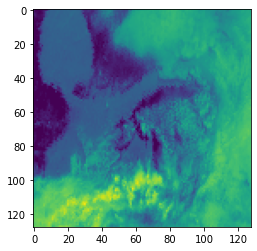

In [44]:
plt.imshow(satelliteImages_filtered[list(labels_filtered.keys())[0]][12][:,:,2])

In [45]:
#Safety check for perfect match
for picType in pictureType:
    for j in range(len(labels_filtered[picType])):
        if(np.datetime64(labels_filtered[picType][j])!=np.datetime64(data_solar_weather_filtered["dateTime"].iloc[j])):
            print("Date mismatch")

In [46]:
data_solar_weather_filtered.columns

Index(['y_x', 'm_x', 'd_x', 'time_x', 'solar_Narva', 'solar_Pärnu',
       'solar_Haapsalu', 'solar_Tallinn-Harku', 'solar_Roomassaare',
       'solar_Tartu-Tõravere', 'solar_Tiirikoja', 'solar_Vilsandi', 'dateTime',
       'y_y', 'm_y', 'd_y', 'time_y', 'temp_Tallinn-Harku',
       'rel_humidity_Tallinn-Harku', 'temp_Roomassaare',
       'rel_humidity_Roomassaare', 'temp_Vilsandi', 'rel_humidity_Vilsandi',
       'temp_Pärnu', 'rel_humidity_Pärnu', 'temp_Tartu-Tõravere',
       'rel_humidity_Tartu-Tõravere', 'temp_Narva', 'rel_humidity_Narva',
       'temp_Tiirikoja', 'rel_humidity_Tiirikoja'],
      dtype='object')

## Transforming points on images and sunlight data to dataset

In [47]:
"""
Function for creating samples out of satellite data. Each row of X contains given number 
(imagesInSample) used to predict future weather. Rows of y are similar to y, although shifted
by one time interval

Arguments
dataDict - dictionary, which contains image data
X_imagetype - the type of images that are requested for X
Y_imagetype - the type of images that are requested for y
imagesInSample - number of images in data row
"""
def createDataSetFromImagesAndStations(satelliteData, satellite_labels, intensityData, 
                                       weatherStationPixels, selectSatelliteChannel=None):
    X = []
    y = []
    
    #For each image
    for i in range(len(satelliteData)):
        selectedImageHour = satellite_labels[i].hour

        
            
        if(isinstance(selectSatelliteChannel, int)):
            selectedImage = satelliteData[i][:,:,selectSatelliteChannel]
            #For each weather station
            for weatherStation in weatherStationPixels.keys():
                selectedStation = weatherStationPixels[weatherStation]
                X+=[[selectedImageHour] +[intensityData.iloc[i][("rel_humidity_"+weatherStation)]] + [intensityData.iloc[i][("temp_"+weatherStation)]] + [ selectedImage[selectedStation[0], selectedStation[1]]]]
                #X+=[[selectedImage[selectedStation[0], selectedStation[1]]]]
                y+=[intensityData.iloc[i][("solar_"+weatherStation)]]
        else:
            if isinstance(selectSatelliteChannel, list):
                selectedImage = satelliteData[i][:,:,selectSatelliteChannel[0]:selectSatelliteChannel[1]+1]
            else:
                selectedImage = satelliteData[i]
            for weatherStation in weatherStationPixels.keys():
                selectedStation = weatherStationPixels[weatherStation]
                X+=[[selectedImageHour]  +[intensityData.iloc[i][("rel_humidity_"+weatherStation)]] + [intensityData.iloc[i][("temp_"+weatherStation)]] + list(selectedImage[selectedStation[0], selectedStation[1]])]
                y+=[intensityData.iloc[i][("solar_"+weatherStation)]]

            
    return np.array(X), np.array(y)

In [48]:
weather_station_loc_pixels

{'Tallinn-Harku': (65, 51),
 'Narva': (92, 42),
 'Pärnu': (68, 71),
 'Roomassaare': (53, 79),
 'Tartu-Tõravere': (85, 68),
 'Tiirikoja': (86, 55),
 'Vilsandi': (47, 77)}

Idee, pane juurde ka mitmes päev on aastas ja mis kell korrelatsioonile!

In [59]:
Xs = dict()
selectedChannels = dict()
selectedChannels["dnm"] = 2
selectedChannels["dnc"] = 1
for picType in pictureType:
    X, y = createDataSetFromImagesAndStations(satelliteImages_filtered[picType], 
                                              labels_filtered[picType],
                                       data_solar_weather_filtered, weather_station_loc_pixels, 
                                       selectSatelliteChannel=selectedChannels[picType])
    Xs[picType] = [X, y]

#Create combo dataset also
if len(pictureType)>1:
    X = Xs[pictureType[0]][0]
    for i in range(1,len(pictureType)):
        X = np.concatenate((X, Xs[pictureType[i]][0][:,:-1]),axis=1)#.shape()
    y = Xs[pictureType[0]][1]
    Xs["combo"] = [X, y]

In [60]:
#Xs["combo"][0][0]

In [61]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [62]:
for key in Xs.keys():
    print("#########")
    print(key)
    X, y = Xs[key]
    lr = LinearRegression()
    lr.fit(X, y)
    print(f"LR {r2_score(y, lr.predict(X))}")
    print(f"LR {mean_squared_error(y, lr.predict(X), squared=False)}")
    lr_ridge = Ridge(0.5)
    lr_ridge.fit(X, y)
    print(f"Ridge {r2_score(y, lr_ridge.predict(X))}")
    print(f"Ridge {mean_squared_error(y, lr_ridge.predict(X), squared=False)}")
    lr_lasso = Lasso(0.5)
    lr_lasso.fit(X, y)
    print(f"Lasso {r2_score(y, lr_lasso.predict(X))}")
    print(f"Lasso {mean_squared_error(y, lr_lasso.predict(X), squared=False)}")
    #Polynomial
    model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                      ('linear', LinearRegression(fit_intercept=False))])
    model = model.fit(X, y)
    print(f"Poly {model.score(X, y)}")
    print(f"Poly {mean_squared_error(y, model.predict(X), squared=False)}")
    #SVR
    regr = make_pipeline(StandardScaler(), SVR(kernel="rbf"))
    regr.fit(X, y)
    print(f"SVR {regr.score(X, y)}")
    print(f"SVR {mean_squared_error(y, regr.predict(X), squared=False)}")
    
#    results_df = pd.DataFrame()
    from sklearn.ensemble import RandomForestRegressor
    rf= RandomForestRegressor()
    rf.fit(X, y)
    print(f"RF {mean_squared_error(y, rf.predict(X), squared = False)}")
    
    from sklearn.tree import DecisionTreeRegressor
    dtr= DecisionTreeRegressor(max_depth = 10)
    dtr.fit(X, y)
    mean_squared_error(y, dtr.predict(X), squared = False)
    print(f"DT {mean_squared_error(y, dtr.predict(X), squared = False)}")
    
    #GLF
#    clf = make_pipeline(StandardScaler(), linear_model.TweedieRegressor(power=0))
#    clf.fit(X, y)
#    print(f"GLM {clf.score(X, y)}")
#    clf = make_pipeline(StandardScaler(), linear_model.TweedieRegressor(power=1))
#    clf.fit(X, y)
#    print(f"GLM {clf.score(X, y)}")


#########
dnc
LR 0.6444194220769841
LR 135.43010026400705
Ridge 0.6444194220749101
Ridge 135.43010026440203
Lasso 0.6444188124741225
Lasso 135.43021635378588
Poly 0.7335826435429662
Poly 117.22694349436877
SVR 0.7057800311023452
SVR 123.19192934234216
RF 31.66036511628427
DT 72.29180122013076
